<a href="https://colab.research.google.com/github/tarekkhaled/detect-social-distance/blob/master/Second%20Approach/fipp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflow-gpu==1.13.1

     |████████████████████████████████| 345.2MB 45kB/s 
     |████████████████████████████████| 368kB 48.4MB/s 
     |████████████████████████████████| 3.2MB 44.6MB/s 
ERROR: tensorflow 2.2.0 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 1.13.1 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement tensorflow-estimator<2.3.0,>=2.2.0, but you'll have tensorflow-estimator 1.13.0 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1


In [2]:

import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import cv2

# Root directory of the project
ROOT_DIR = os.path.abspath("/content/drive/My Drive/test mask")

import warnings
warnings.filterwarnings("ignore")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
#Import COCO config
sys.path.append(os.path.join(ROOT_DIR, ""))  # To find local version
import coco

%matplotlib inline

# Directory to save logs and trained model
#MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir='mask_rcnn_coco.hy',config=config)

# Load weights trained on MS-COCO
model.load_weights('mask_rcnn_coco.h5', by_name=True)
# COCO Class names
class_names =['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [0]:
def mrcnn(img): #apply mask rcnn and return maskes and boundary box coordinates
  results = model.detect([img], verbose=1)
  r = results[0]
  return r['masks'], r['class_ids'],r['rois']

def shape(image): #solve problem of different shape of input image
  
  if image.shape[2]==3: #if 3 channels
    img=image
  elif image.shape[2]==4: #if 4 channels
    img = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
  return img

def check_class(maskas,classes,rois):# check class for every object and focus on person class (class=1) 
  xy=[]
  maskes=[]
  for x in range(0,maskas.shape[2]):
    if classes[x]==1: #that's mean class person
      
      xy.append(rois[x:3])
      maskes.append(maskas[:,:,x])
  maskes=np.array(maskes,np.int32)
  return maskes,xy


def factor(maskes):
  """
  calculate average of sum of objects height and compare it with average person height (170cm) to get ratio between  real distance and distance
  in image 
  """
  spaces=[]
  height=[]
  for itt in range(0,maskes.shape[0]):
    #get all coordinates of white pixels in maskes 
    indices_mask=np.where(maskes[itt,:,:]==[1])
    coordinates_mask=list(zip(indices_mask[0],indices_mask[1]))
    coo_mask=np.array(coordinates_mask,np.int32)
    #get min max for x,y 
    xmin=np.amin(coo_mask[:,1])
    xmax=np.amax(coo_mask[:,1])
    ymin=np.amin(coo_mask[:,0])
    ymax=np.amax(coo_mask[:,0])
    spaces.append((xmax+xmin)/2) 
    height.append(ymax-ymin)# height in image
  avgx=np.array(spaces,np.float32)
  avg=(170/(np.sum(np.array(height))/maskes.shape[0]))#ratio between real distance and image distance  
  return avg,avgx

def compare(spaces,ratio):
  """
here we check distance betwenn  objects
  """
  itx=0
  ity=0
  wrong_objects=set()
  all_distances=[]
  for itx in range(0,spaces.shape[0]):
    for ity in range(itx,spaces.shape[0]):
     if itx<ity:
      dist=(ratio*abs(spaces[itx]-spaces[ity])) #multiply ratio by image distance to get real distance
      all_distances.append(dist)
      print(dist,":",itx,"  : ",ity)
      if dist<180 :
        wrong_objects.add(itx)#add wrong objects (dist between another object less than 1.8)
        wrong_objects.add(ity)

  return all_distances,wrong_objects

def merge_masks_v2(mask):
  if mask.shape[0]>2:
    mask_from_rcnn = cv2.bitwise_or(mask[0,:,:],mask[1,:,:])
    for t in range(2,mask.shape[0]):
        blank=mask_from_rcnn
        mask_from_rcnn=cv2.bitwise_or(mask[t,:,:],blank)
  else :
    mask_from_rcnn=mask[0,:,:]
  return mask_from_rcnn



In [0]:
def testing(path):
  image= skimage.io.imread(path)
  img=shape(image)
  maskas,classes,rois=mrcnn(img)
  maskas=maskas.astype(int)
  maskes,roiss=check_class(maskas,classes,rois)
  new_maskes=list()
  new_rois=list()
  x=dict()
  for itt in range(0,maskes.shape[0]):
    indices_mask=np.where(maskes[itt,:,:]==[1])
    coordinates_mask=list(zip(indices_mask[0],indices_mask[1]))
    coo_mask=np.array(coordinates_mask,np.int32)
    xmin=np.amin(coo_mask[:,1])
    x[itt]=xmin

  new_x=sorted(x.items(), key =lambda kv:(kv[1], kv[0]))
  seq=[]
  for it in range(maskes.shape[0]) :
        seq.append(new_x[it][0])
        new_maskes.append(maskes[new_x[it][0],:,:])
        new_rois.append(rois[new_x[it][0]])
  new_maskes=np.array(new_maskes,np.int32)
  new_rois=np.array(new_rois,np.int32)
  seq=np.array(seq,np.int32)
  factorr,spaces=factor(new_maskes)

  all_dist,wrong_objects=compare(spaces,factorr)
  for it in wrong_objects:
    
    y1=rois[it][0]
    x1=rois[it][1]
    y2=rois[it][2]
    x2=rois[it][3]
    COLOR = ([255,0,0]) #red
    cv2.rectangle(img, (x1,y1),(x2,y2), COLOR, 2)
  arr=np.fromiter(wrong_objects, int, len(wrong_objects))
  diff=np.setdiff1d(seq, arr)

  for i in diff:
    y1=rois[i][0]
    x1=rois[i][1]
    y2=rois[i][2]
    x2=rois[i][3]
    COLOR = ([0,255,0]) #green
    cv2.rectangle(img, (x1,y1),(x2,y2), COLOR, 2)
  plt.imshow(img)
  plt.show()


Processing 1 images
image                    shape: (653, 980, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
233.4390243902439 : 0   :  1
514.560975609756 : 0   :  2
682.9024390243902 : 0   :  3
281.1219512195122 : 1   :  2
449.4634146341463 : 1   :  3
168.34146341463415 : 2   :  3


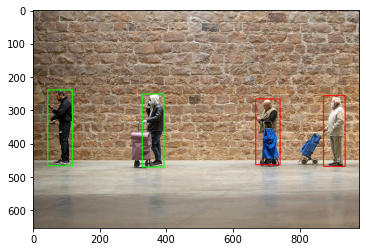

Processing 1 images
image                    shape: (675, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
183.5560344827586 : 0   :  1
406.0215517241379 : 0   :  2
222.4655172413793 : 1   :  2


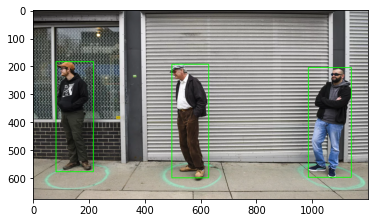

Processing 1 images
image                    shape: (500, 955, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
141.60241874527588 : 0   :  1
285.77475434618293 : 0   :  2
406.30385487528343 : 0   :  3
144.17233560090702 : 1   :  2
264.70143613000755 : 1   :  3
120.52910052910053 : 2   :  3


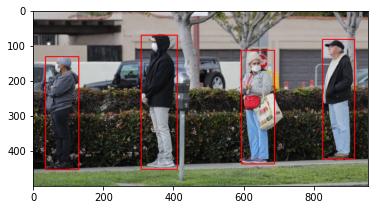

Processing 1 images
image                    shape: (501, 752, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
310.3341584158416 : 0   :  1
605.940594059406 : 0   :  2
905.7549504950496 : 0   :  3
1337.0668316831684 : 0   :  4
295.6064356435644 : 1   :  2
595.4207920792079 : 1   :  3
1026.7326732673268 : 1   :  4
299.81435643564356 : 2   :  3
731.1262376237624 : 2   :  4
431.31188118811883 : 3   :  4


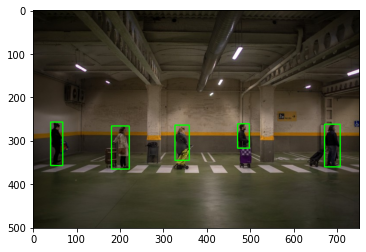

Processing 1 images
image                    shape: (766, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
100.71663019693655 : 0   :  1
236.02844638949674 : 0   :  2
354.04266958424506 : 0   :  3
471.2199124726477 : 0   :  4
563.8457330415755 : 0   :  5
135.31181619256017 : 1   :  2
253.32603938730853 : 1   :  3
370.5032822757112 : 1   :  4
463.12910284463896 : 1   :  5
118.01422319474837 : 2   :  3
235.191466083151 : 2   :  4
327.8172866520788 : 2   :  5
117.17724288840263 : 3   :  4
209.8030634573304 : 3   :  5
92.6258205689278 : 4   :  5


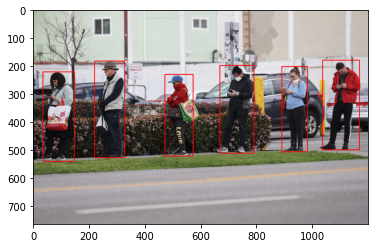

Processing 1 images
image                    shape: (957, 1300, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
38.871532453541604 : 0   :  1
73.89711823323458 : 0   :  2
108.51063829787233 : 0   :  3
141.88796121734447 : 0   :  4
172.51817936978185 : 0   :  5
35.02558577969297 : 1   :  2
69.63910584433073 : 1   :  3
103.01642876380285 : 1   :  4
133.64664691624023 : 1   :  5
34.613520064637754 : 2   :  3
67.99084298410988 : 2   :  4
98.62106113654725 : 2   :  5
33.37732291947212 : 3   :  4
64.0075410719095 : 3   :  5
30.63021815243738 : 4   :  5


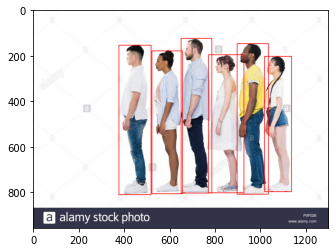

Processing 1 images
image                    shape: (867, 1300, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1300.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
52.325406381697775 : 0   :  1
105.6742925948224 : 0   :  2
156.72034918723662 : 0   :  3
209.81336544250453 : 0   :  4
53.34888621312463 : 1   :  2
104.39494280553885 : 1   :  3
157.48795906080676 : 1   :  4
51.04605659241421 : 2   :  3
104.13907284768213 : 2   :  4
53.09301625526792 : 3   :  4


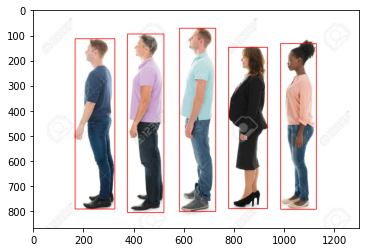

Processing 1 images
image                    shape: (353, 612, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
68.18596171376481 : 0   :  1
140.09115770282588 : 0   :  2
202.38833181403828 : 0   :  3
71.90519598906107 : 1   :  2
134.20237010027347 : 1   :  3
62.2971741112124 : 2   :  3


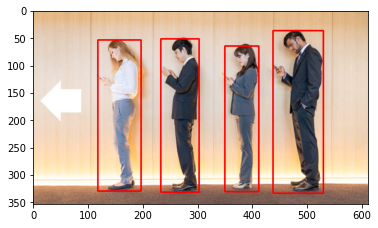

Processing 1 images
image                    shape: (800, 1200, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1200.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
59.364250614250615 : 0   :  1
111.0534398034398 : 0   :  2
163.2125307125307 : 0   :  3
222.42014742014743 : 0   :  4
279.90479115479116 : 0   :  5
51.68918918918919 : 1   :  2
103.8482800982801 : 1   :  3
163.05589680589682 : 1   :  4
220.54054054054055 : 1   :  5
52.159090909090914 : 2   :  3
111.36670761670761 : 2   :  4
168.85135135135135 : 2   :  5
59.20761670761671 : 3   :  4
116.69226044226045 : 3   :  5
57.48464373464374 : 4   :  5


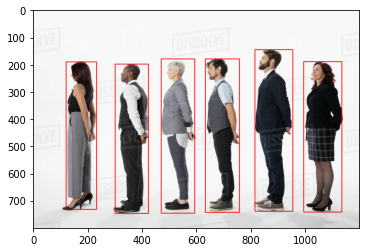

In [15]:
from os.path import isfile, join
pathIn='/content/drive/My Drive/test mask/samples'
file = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
 
files = sorted(file,key=lambda x: int(os.path.splitext(x)[0]))
  
for i in range(len(files)):
  filename=pathIn + '/'+files[i]
  testing(filename)